#Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (17,8)
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(17,8)})
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.metrics import cohen kappa score (not worked, implemented on my own)

# Classes and functions

In [58]:
def out_classifier(X_train, y_train, X_test, y_test):
    gnb = GaussianNB();
    model = gnb.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.sum(y_test == y_pred) / len(y_test)
    return y_pred, accuracy

def cohen(y1, y2):
    confusion = confusion_matrix(y1, y2)
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)
    w_mat = np.ones([n_classes, n_classes], dtype=int)
    w_mat.flat[:: n_classes + 1] = 0
    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    return 1 - k

def vary_test_size(link, target):
    accuracy_in = []
    accuracy_out = []
    xAxis = []
    for size in range(5, 100, 5):
      data = DatasetFunctions(link)
      s = size/100
      data.split(target = target, test_size = s)
      data.classify()
      xAxis.append(size)
      accuracy_in.append(data.acc_in)
      accuracy_out.append(data.acc_out)
    
    plt.plot(xAxis,accuracy_in, label = "Accuracy inBox", marker = '.')
    plt.plot(xAxis,accuracy_out, marker = '.', label = "Accuracy outOfBox")
    plt.title('Accuracy vs test size')
    plt.xlabel('test size (percentage)')
    plt.ylabel('prediction accuracy')
    plt.legend()
    plt.show()



In [59]:
class NaiveBayesClassifier():

    def calc_prior(self, features, target):
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()
        return self.prior

    def calc_statistics(self, features, target):
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
        return self.mean, self.var

    def gaussian_density(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob

    def calc_posterior(self, x):
        posteriors_for_one = []
        for i in range(self.count):
            prior = np.log(self.prior[i])
            conditional = np.sum(np.log(self.gaussian_density(i, x)))
            posterior = prior + conditional
            posteriors_for_one.append(posterior)
        self.posteriors.append(posteriors_for_one)
        return self.classes[np.argmax(posteriors_for_one)]

    def fit(self, features, target):
        self.features = features
        self.target = target
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        self.posteriors = []

    def predict(self, X_test, y_test):
        y_prediction = [self.calc_posterior(f) for f in X_test.to_numpy()]
        accuracy = np.sum(y_test == y_prediction) / len(y_test)
        return y_prediction, accuracy

In [60]:
class DatasetFunctions():

    def __init__(self, link, index_col = None):
        self.data = pd.read_csv(link, index_col= index_col)
        print(self.data.head())

    def split(self, target, test_size, random_state = None):
        self.target = target
        y = self.data[target].copy()
        X = self.data.copy()
        X = X.drop(columns = [target])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size)
        print("Shape of the whole dataset is {}".format(self.data.shape))
        print("Shape of the feature train set is {}".format(self.X_train.shape))
        print("Shape of the target train set is {}".format(self.y_train.shape))
        print("Shape of the feature test set is {}".format(self.X_test.shape))
        print("Shape of the target test set is {}\n".format(self.y_test.shape))

    def visualize(self):

        countplot = plt.figure(1)
        ax_cp = sns.countplot(self.data[self.target])
        countplot.suptitle("Count of samples in each class")
        ax_cp.set(xlabel="Class", ylabel = "Count")
        countplot.show()

        cor_m = self.X_train.corr()
        heatmap = plt.figure(2)
        heatmap.suptitle("Correlation matrix")
        ax_hm = sns.heatmap(cor_m, annot=True, annot_kws={"size": 20})
        heatmap.show()

        pairplot = plt.figure(3)
        pairplot.suptitle("Pairplot")
        sns.pairplot(self.data, hue = self.target, corner = True, palette = "bright")
        pairplot.show()


    def classify(self):
        self.pred_out, self.acc_out = out_classifier(self.X_train, self.y_train, self.X_test, self.y_test)
        x = NaiveBayesClassifier()
        x.fit(self.X_train, self.y_train)
        self.pred_in, self.acc_in = x.predict(self.X_test, self.y_test)
        self.scores = x.posteriors
        print("Both classifiers trained and tested!\n")
    
    def show_accuracy(self):
        print("\nAccuracy of pre-build GaussianNB classifier is {:2.2%}".format(self.acc_out))
        print("Accuracy of our GaussianNB classifier is {:2.2%}".format(self.acc_in))
        print("\nConfusion matrix")
        print(confusion_matrix(self.y_test, self.pred_in))
        print(classification_report(self.y_test, self.pred_in, digits=3))
        print("Cohen-kappa score {}".format(cohen(y1 = self.y_test, y2=self.pred_in)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        scores_full = np.array(self.scores)
        y_test_labels = LabelBinarizer().fit_transform(self.y_test)
        n_classes = 3
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_labels[:, i], scores_full[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_labels.ravel(), scores_full.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.figure()
        lw = 2
        plt.plot(fpr[0], tpr[0], color='darkorange',
                  lw=lw, label='ROC curve class 1 (area = %0.2f)' % roc_auc[0])
        plt.plot(fpr[1], tpr[1], color='navy',
                  lw=lw, label='ROC curve class 2 (area = %0.2f)' % roc_auc[1])
        plt.plot(fpr[2], tpr[2], color='red',
                  lw=lw, label='ROC curve class 3 (area = %0.2f)' % roc_auc[2])
        plt.plot(fpr["micro"], tpr["micro"], color='green',
                 label='ROC curve micro average (area = %0.2f)' % roc_auc["micro"], linestyle = '--', lw = 3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show() 


      

# Working with data

In [61]:
"""These data are the results of a chemical analysis of wines grown in the same region in Italy 
but derived from three different cultivars. The analysis determined the quantities of 13 constituents 
found in each of the three types of wines."""

wine_3classes = DatasetFunctions("https://raw.githubusercontent.com/Zhanna-Lopuliak/ML_KNU/main/wine_data.csv")
wine_3classes.split("Class", test_size = 0.3)
wine_3classes.visualize()

   Class  Alcohol  Malic acid  ...   Hue  OD280/OD315   Proline
0      1    14.23        1.71  ...  1.04          3.92     1065
1      1    13.20        1.78  ...  1.05          3.40     1050
2      1    13.16        2.36  ...  1.03          3.17     1185
3      1    14.37        1.95  ...  0.86          3.45     1480
4      1    13.24        2.59  ...  1.04          2.93      735

[5 rows x 14 columns]
Shape of the whole dataset is (178, 14)
Shape of the feature train set is (124, 13)
Shape of the target train set is (124,)
Shape of the feature test set is (54, 13)
Shape of the target test set is (54,)



Both classifiers trained and tested!


Accuracy of pre-build GaussianNB classifier is 100.00%
Accuracy of our GaussianNB classifier is 98.15%

Confusion matrix
[[22  0  0]
 [ 1 16  0]
 [ 0  0 15]]
              precision    recall  f1-score   support

           1      0.957     1.000     0.978        22
           2      1.000     0.941     0.970        17
           3      1.000     1.000     1.000        15

    accuracy                          0.981        54
   macro avg      0.986     0.980     0.982        54
weighted avg      0.982     0.981     0.981        54

Cohen-kappa score 0.9717720857292211


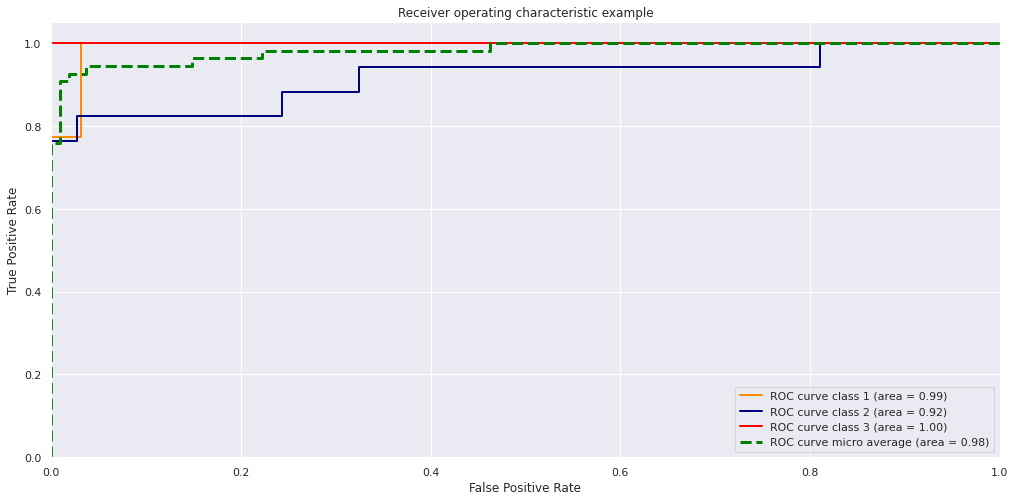

In [62]:
wine_3classes.classify()
wine_3classes.show_accuracy()

   Class  Alcohol  Malic acid  ...   Hue  OD280/OD315   Proline
0      1    14.23        1.71  ...  1.04          3.92     1065
1      1    13.20        1.78  ...  1.05          3.40     1050
2      1    13.16        2.36  ...  1.03          3.17     1185
3      1    14.37        1.95  ...  0.86          3.45     1480
4      1    13.24        2.59  ...  1.04          2.93      735

[5 rows x 14 columns]
Shape of the whole dataset is (178, 14)
Shape of the feature train set is (169, 13)
Shape of the target train set is (169,)
Shape of the feature test set is (9, 13)
Shape of the target test set is (9,)

Both classifiers trained and tested!

   Class  Alcohol  Malic acid  ...   Hue  OD280/OD315   Proline
0      1    14.23        1.71  ...  1.04          3.92     1065
1      1    13.20        1.78  ...  1.05          3.40     1050
2      1    13.16        2.36  ...  1.03          3.17     1185
3      1    14.37        1.95  ...  0.86          3.45     1480
4      1    13.24        2.59  .

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


   Class  Alcohol  Malic acid  ...   Hue  OD280/OD315   Proline
0      1    14.23        1.71  ...  1.04          3.92     1065
1      1    13.20        1.78  ...  1.05          3.40     1050
2      1    13.16        2.36  ...  1.03          3.17     1185
3      1    14.37        1.95  ...  0.86          3.45     1480
4      1    13.24        2.59  ...  1.04          2.93      735

[5 rows x 14 columns]
Shape of the whole dataset is (178, 14)
Shape of the feature train set is (8, 13)
Shape of the target train set is (8,)
Shape of the feature test set is (170, 13)
Shape of the target test set is (170,)

Both classifiers trained and tested!



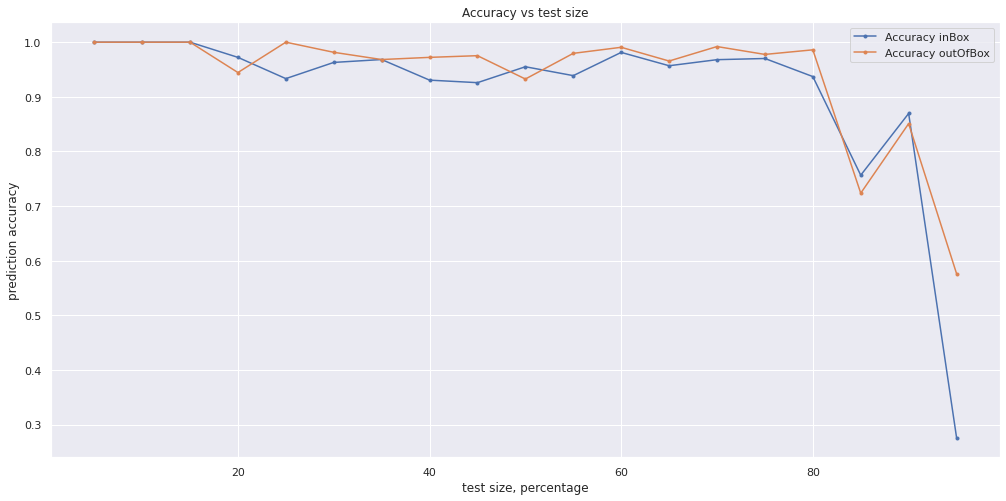

In [63]:
vary_test_size("https://raw.githubusercontent.com/Zhanna-Lopuliak/ML_KNU/main/wine_data.csv", target = "Class")

In [9]:
wine_data = pd.read_csv("https://raw.githubusercontent.com/Zhanna-Lopuliak/ML_KNU/main/wine_data.csv")
iris_data = pd.read_csv("https://raw.githubusercontent.com/Zhanna-Lopuliak/ML_KNU/main/Iris.csv", index_col = "Id")
